In [6]:
import numpy as np
import scipy.stats
import os
import re

import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.multitest
import seaborn as sns

import csv
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
%matplotlib inline

In [2]:
# Define file paths
data_dir = '../data'
pupil_dir = '../data/SingleTrialPupilData'
eeg_dir = '../data/SingleTrialEEGData'
plot_dir = '../plots'

## Model Fitting

Skip if loading previously fitted data
- Fit to mean pupil dilation for "included" trials

In [3]:
files_pupil = os.listdir(pupil_dir)
files_eeg = os.listdir(eeg_dir)

In [4]:
def function(lr, file, V_0):

    """
    Updates and computes the correlation between V values and mean EEG frequency data.
    
    Parameters:
        - lr (float): 
            Learning rate for updating V values.
        - file (str): 
            Filename of the pupil data CSV.
        - V_0 (list or array): 
            Initial V values.
    
    Returns:
        float: Negative Pearson correlation coefficient between updated V values and mean EEG frequencies.
    """

    # Extract participant identifier from the filename
    res = re.search('(...)_PupilDiameterProcessed', file)
    participant = res.group(1)

    # Find the corresponding EEG file
    match_eeg = [s for s in files_eeg if participant in s]

    # Load the pupil and EEG data
    df_pupil = pd.read_csv(os.path.join(pupil_dir, file))
    df_eeg = pd.read_csv(os.path.join(eeg_dir, match_eeg[0]))

    # Calculate the cumulative number of trials up to each block
    block_1 = np.sum(df_eeg['Block'] == 1)
    block_2 = block_1 + np.sum(df_eeg['Block'] == 2)
    block_3 = block_2 + np.sum(df_eeg['Block'] == 3)
    block_4 = block_3 + np.sum(df_eeg['Block'] == 4)

    # Calculate the mean pupil diameter for each trial
    mean_pupil = np.array(np.mean(df_pupil.loc[:,'0':'3299'], axis = 1))
    df_pupil['means'] = mean_pupil

    # Recode 'side' as numerical values
        # 'side' refers to the direction of the rock
    df_pupil['side'] = (df_pupil['start_new_trial_condition']== 'Left') * 0 + (
        df_pupil['start_new_trial_condition']== 'MiddleLow') * 1 + (
        df_pupil['start_new_trial_condition']== 'Right') * 2 # Recode side as numbers

    # Initialize V values
    V = np.array((V_0))
    all_V = np.zeros((np.shape(df_eeg)[0] + 1, 3))
    all_V[0, :] = V

    # Calculate V values for each trial across blocks
    for block in [1,2,3,4]:

        # Skip block 3 for participant 5, as pain values are missing
        if participant == 'P05' and (block == 3 or block == 4):
            continue
        if participant == 'P14' and block == 4:
            continue
        
        # Get data for block
        this_block = df_eeg[df_eeg['Block'] == block]

        # Update V values for each trial
        for i_t, trial in enumerate(this_block['epoch']):

            # Determine cue side based on 'type'
            if this_block.loc[trial-1, 'type'] == 'left':
                cue_side = 0
            elif this_block.loc[trial-1, 'type'] == 'middle':
                cue_side = 1
            elif this_block.loc[trial-1, 'type'] == 'right':
                cue_side = 2
            else:
                print('Error: Unrecognized cue side.')

            # Determine reward value based on 'pain'
            if this_block.loc[trial-1,'pain'] == 'PCollShock':
                r = 1
            elif this_block.loc[trial-1,'pain'] == 'nPCollNoShock':
                r = 0
            elif this_block.loc[trial-1,'pain'] == 'PCollNoShock':
                r = 0
            elif np.logical_and(np.isnan(this_block.loc[trial-1,'pain']), block == 2 or block == 4):
                r = 0
            else:
                if this_block.loc[trial-1, 'type'] == 'middle':
                    r = 0
                else:
                    r = 1

            # Update V
            V[cue_side] = V[cue_side] * (1 - lr) + lr * r
            all_V[trial, :] = V
    
    # Create a mask to exclude the last trial
    V_incl = ~np.all(df_pupil.loc[:,'0':'3299'] == 0, axis = 1) # Find trials with no missing pupil
    V_incl[np.shape(V_incl)[0] + 1] = False
    pupil_incl = ~np.all(df_pupil.loc[:,'0':'3299'] == 0, axis = 1) # Find trials with no missing data

    
    # Exclude the last trials for participant 5 and 14, as pain values are missing
    if participant == 'P05':
        pupil_incl[180::] = False
        V_incl[180::] = False
    elif participant == 'P14':
        pupil_incl[241::] = False
        V_incl[241::] = False

    # Calculate the correlation between V values and mean pupil diameter
    correlation = scipy.stats.pearsonr(
                all_V[V_incl, df_pupil.loc[pupil_incl, 'side']],
                df_pupil.loc[pupil_incl, 'means'])[0]

    return (-correlation)

In [7]:
all_tonic_sides = pd.read_csv(os.path.join(data_dir, 'tonicpainsides.csv'))

In [8]:
# Define boundary constraints for optimization. 
# Lower bound (lb) is set to 0.0 and upper bound (ub) is set to 1.0.
bnds = scipy.optimize.Bounds(lb=0.01, ub=0.99)

In [9]:
# Intialize DataFrame to save relevant trial data (pupil, V values, participant ID, and congruency)
all_data = pd.DataFrame()

# Intialize DataFrame to save relevant model fitting data (ID, learning rate, maximum correlation)
df_model = pd.DataFrame()

for i_file, file in enumerate(files_pupil):
    print('========= \n File : {} of {}'.format(i_file + 1, len(files_pupil)))
    try:

        # Initialize V Values for RL
        V_0 = np.array((0.3, 0.3, 0.3)) #np.zeros((3))
        
        # Extract the participant ID from the file name
        ID = int(re.split('_PupilDiameterProcessed_ST.csv', file)[0][1::])

        # Extract the tonic pain sides for the participant
        tonic_sides  = all_tonic_sides.loc[all_tonic_sides['ID'] == ID, 'Extn1' : 'Extn2'].values[0].astype('str')
        tonic_sides[np.where(tonic_sides == '1')] = 'left'
        tonic_sides[np.where(tonic_sides == '2')] = 'right'
        
        # Fit the model
        fit_res = scipy.optimize.minimize(function, (0.5, ), args=(file, V_0), method= 'SLSQP', bounds = bnds)
        print(fit_res.message)
        
        # Extract participant identifier from the filename
        res_file = re.search('(...)_PupilDiameterProcessed', file)
        participant = res_file.group(1)

        # Find the corresponding EEG file
        match_eeg = [s for s in files_eeg if participant in s]

        # Load pupil and EEG data
        df_pupil = pd.read_csv(os.path.join(pupil_dir, file))
        df_eeg = pd.read_csv(os.path.join(eeg_dir, match_eeg[0]))


        # Recode 'side' as numerical values
            # 'side' refers to the direction of the rock
        df_eeg['side'] = (df_eeg['type']== 'left') * 0 + \
            (df_eeg['type']== 'middle') * 1 + \
            (df_eeg['type']== 'right') * 2

        # Calculate the mean pupil diameter for each trial and timebin
        timebin_1 = np.array(np.mean(df_pupil.loc[:,'0':'799'], axis = 1))
        timebin_2 = np.array(np.mean(df_pupil.loc[:,'800':'1799'], axis = 1))
        timebin_3 = np.array(np.mean(df_pupil.loc[:,'1800':'2799'], axis = 1))
        timebin_4 = np.array(np.mean(df_pupil.loc[:,'2800':'3299'], axis = 1))

        df_pupil['t1'] = timebin_1
        df_pupil['t2'] = timebin_2
        df_pupil['t3'] = timebin_3
        df_pupil['t4'] = timebin_4
        
        # Initialize V values
        V = np.array((V_0))
        all_V = np.zeros((np.shape(df_eeg)[0] + 1, 3))
        all_V[0, :] = V
        
        # Save learning rate from model fitting
        lr = fit_res.x
        
        # Calculate V values for each trial across blocks
        for block in [1,2,3,4]:

            # Skip block 3 for participant 5, as pain values are missing
            if ID == 5 and (block == 3 or block == 4):
                print('Skipping block 3 and 4 for participant 5')
                continue
            if ID == 14 and block == 4:
                print('Skipping block 4 for participant 14')
                continue
            
            # Extract data for block
            this_block = df_eeg[df_eeg['Block'] == block]

            # Loop over trials and update V values
            for i_t, trial in enumerate(this_block['epoch']):

                if ID == 14 and trial>241:
                    print('Skipping trial {} in block 3 for participant 14'.format(trial))
                    continue

                # Determine cue side based on 'type'
                if this_block.loc[trial-1, 'type'] == 'left':
                    cue_side = 0
                elif this_block.loc[trial-1, 'type'] == 'middle':
                    cue_side = 1
                elif this_block.loc[trial-1, 'type'] == 'right':
                    cue_side = 2
                else:
                    print('what is going on with the cue sides?')


                # Determine reward value based on 'pain'
                if this_block.loc[trial-1,'pain'] == 'PCollShock':
                    r = 1
                elif this_block.loc[trial-1,'pain'] == 'nPCollNoShock':
                    r = 0
                elif this_block.loc[trial-1,'pain'] == 'PCollNoShock':
                    r = 0
                elif np.logical_and(np.isnan(this_block.loc[trial-1,'pain']), block == 2 or block == 4):
                    r = 0
                else:
                    print('Error: Unrecognized pain value: {}'.format(this_block.loc[trial-1,'pain']))
                    if this_block.loc[trial-1, 'type'] == 'middle':
                        r = 0
                    else:
                        r = 1
                
                # Update V based on reward and learning rate
                V[cue_side] = V[cue_side] * (1 - lr) + lr * r
                all_V[trial, :] = V
        
        # Create a mask for which trials to include
        V_incl = ~np.all(df_pupil.loc[:,'0':'3299'] == 0, axis = 1)
        V_incl[np.shape(V_incl)[0] + 1] = False
        pupil_incl = ~np.all(df_pupil.loc[:,'0':'3299'] == 0, axis = 1)

        # Exclude the last trials for participant 5 and 14, as pain values are missing
        if participant == 'P05':
            pupil_incl[180::] = False
            V_incl[180::] = False
        elif participant == 'P14':
            pupil_incl[241::] = False
            V_incl[241::] = False

        # Create a DataFrame for the V values for the included trials
        df_V = pd.DataFrame(all_V[
            V_incl, 
            df_eeg.loc[pupil_incl, 'side']],
            columns = ['V'])

        # Create a DataFrame for the participant ID (repeated for each trial)
        df_ID = pd.DataFrame(np.repeat(ID, np.shape(df_V)[0]), columns = ['ID'])

        # Filter the pupil data
        df_pupil_in = df_pupil.loc[pupil_incl, 't1': 't4']
        
        # Congruency Information
        cong = np.logical_or(
            np.logical_and(df_eeg['Block'] == 2, df_eeg['type'] == tonic_sides[0]),
            np.logical_and(df_eeg['Block'] == 4, df_eeg['type'] == tonic_sides[1]))
        incong = np.logical_or(
            np.logical_and(df_eeg['Block'] == 2, df_eeg['type'] == tonic_sides[1]),
            np.logical_and(df_eeg['Block'] == 4, df_eeg['type'] == tonic_sides[0]))

        # Create a DataFrame for congruency information (congruent or incongruent on extinction blocks; nan for acquisition blocks)
        df_congr = (np.ones((np.shape(df_eeg)[0])) * np.nan).astype('str')
        df_congr[cong] = "congr" # congruent
        df_congr[incong] = "incongr" # incongruent

        # Filter congruency data for included trials
        df_congr = pd.DataFrame(df_congr[pupil_incl], columns = ['congruency'])
                
        # Add to dataframe
        new_row = pd.concat([df_pupil_in,df_V, df_ID, df_congr], axis = 1)
        all_data = pd.concat([all_data, new_row])

        # Append the model fitting data
        df_model = pd.concat([df_model, pd.DataFrame({'ID': ID, 'lr': lr, 'max_corr': -fit_res.fun})])
    
    except:
        print('__something went wrong')

all_data.reset_index(drop = True)

print('DONE')

 File : 1 of 26
Optimization terminated successfully
 File : 2 of 26
Optimization terminated successfully
 File : 3 of 26
Optimization terminated successfully
 File : 4 of 26
Optimization terminated successfully
Skipping block 3 and 4 for participant 5
Skipping block 3 and 4 for participant 5
 File : 5 of 26
Optimization terminated successfully
 File : 6 of 26
Optimization terminated successfully
 File : 7 of 26
Optimization terminated successfully
 File : 8 of 26
Optimization terminated successfully
 File : 9 of 26
Optimization terminated successfully
Error: Unrecognized pain value: nan
 File : 10 of 26
Optimization terminated successfully
 File : 11 of 26
Optimization terminated successfully
Error: Unrecognized pain value: nan
Error: Unrecognized pain value: nan
 File : 12 of 26
Optimization terminated successfully
Skipping trial 242 in block 3 for participant 14
Skipping trial 243 in block 3 for participant 14
Skipping trial 244 in block 3 for participant 14
Skipping trial 245 in bl

In [10]:
df_model.to_csv(os.path.join(data_dir, 'pupil_model_fitting_results.csv'), index = False)

In [11]:
# Check DataFrame
all_data

,t1,t2,t3,t4,V,ID,congruency
0,0.070559,0.041776,0.247400,0.220276,0.300000,2.0,nan
1,-0.090062,-0.220444,-0.205470,-0.337087,0.300000,2.0,nan
2,0.034449,0.019725,0.280007,0.278826,0.313817,2.0,nan
3,0.032575,-0.051917,-0.075108,-0.124938,0.313817,2.0,nan
4,-0.058258,-0.214787,0.010181,0.163215,0.300000,2.0,nan
...,...,...,...,...,...,...,...
355,-0.080276,-0.251930,-0.316122,-0.298939,0.018540,30.0,incongr
356,-0.051633,-0.171034,-0.031295,-0.021038,0.018700,30.0,congr
357,-0.014987,-0.295661,-0.442957,-0.264412,0.016856,30.0,congr
358,-0.123431,-0.200313,-0.285149,-0.415803,0.000001,30.0,nan


In [12]:
all_data.to_csv(os.path.join(data_dir, 'pupil_v_values.csv'), index = False)

## Load Data

In [3]:
# Read csv file into DataFrame
all_data = pd.read_csv(os.path.join(data_dir, 'pupil_v_values.csv'))

## Regression

In [32]:
# Reshape the 'all_data' DataFrame from wide to long format, using 'ID', 'V', and 'congruency' as identifier variables.
dat = pd.melt(all_data, id_vars = ['ID','V', 'congruency'], var_name = 'timebin', value_name = 'pupil')
dat['ID'] = dat['ID'].astype('object')
dat

,ID,V,congruency,timebin,pupil
0,2.0,0.300000,NaN,t1,0.070559
1,2.0,0.300000,NaN,t1,-0.090062
2,2.0,0.313817,NaN,t1,0.034449
3,2.0,0.313817,NaN,t1,0.032575
4,2.0,0.300000,NaN,t1,-0.058258
...,...,...,...,...,...
36195,30.0,0.018540,incongr,t4,-0.298939
36196,30.0,0.018700,congr,t4,-0.021038
36197,30.0,0.016856,congr,t4,-0.264412
36198,30.0,0.000001,NaN,t4,-0.415803


## Assumption Check

/var/folders/v4/1zbrx95516919mf320cfydlh0000gn/T/ipykernel_44285/3218353808.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  var_corr = dat.corr()


<Axes: >

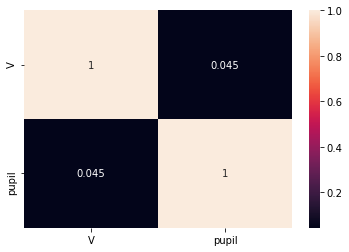

In [34]:
# get table of variable correlations
var_corr = dat.corr()
# plot the heatmap
sns.heatmap(var_corr, xticklabels=var_corr.columns, yticklabels=var_corr.columns, annot=True)

/Users/sarah/anaconda3/envs/py3.8/lib/python3.8/site-packages/seaborn/distributions.py:453: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges[:-1], name="edges"),
/Users/sarah/anaconda3/envs/py3.8/lib/python3.8/site-packages/seaborn/distributions.py:454: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(np.diff(edges) * shrink, name="widths"),


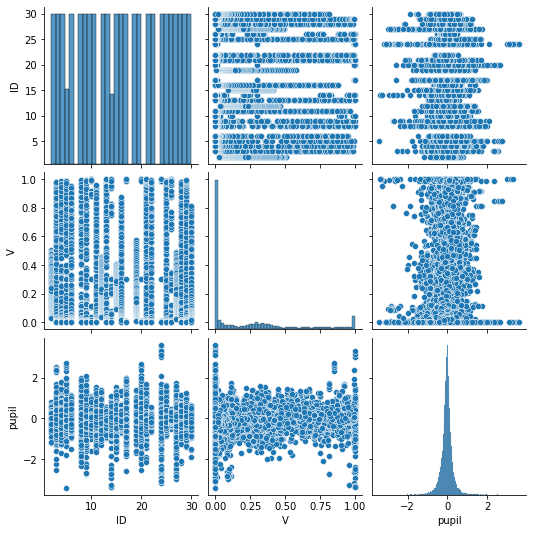

In [33]:
sns.pairplot(dat)

### Pupil ~ V * timebin

In [36]:
# Performing an ordinary least squares (OLS) regression analysis, modeling 'pupil' as a function of 'V' and 'timebin',including their interaction
res = smf.ols('pupil ~ ID +  V*timebin', data = dat).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  pupil   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     42.46
Date:                Tue, 10 Sep 2024   Prob (F-statistic):          3.90e-260
Time:                        11:04:11   Log-Likelihood:                -12285.
No. Observations:               35696   AIC:                         2.464e+04
Df Residuals:                   35663   BIC:                         2.492e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0085      0.010     -0.854      0.393      -0.028       0.011
ID[T.3.0]           0.0417      0.013      3.272      0.001       0.017       0.067
ID[T.4.0]           0.0086      0.013      0.677      0.499      -0.016       0.034
ID[T.5.0]           0.0986      0.016      6.321      0.000       0.068       0.129
ID[T.6.0]           0.0077      0.013      0.606      0.544      -0.017       0.033
ID[T.8.0]          -0.0250      0.013     -1.961      0.050      -0.050   -1.11e-05
ID[T.9.0]          -0.0148      0.013     -1.164      0.245      -0.040       0.010
ID[T.10.0]          0.0053      0.013      0.415      0.678      -0.020       0.030
ID[T.11.0]         -0.0050      0.013     -0.397      0.692      -0.030       0.020
ID[T.12.0]          0.0270      0.013      2.123      0.034       0.002       0.052
ID[T.13.0]         -0.0031      0.013     -0.245      0.807      -0.028       0.022
ID[T.14.0]         -0.1446      0.019     -7.603      0.000      -0.182      -0.107
ID[T.15.0]          0.0127      0.013      1.000      0.317      -0.012       0.038
ID[T.16.0]          0.0327      0.013      2.568      0.010       0.008       0.058
ID[T.17.0]         -0.0504      0.013     -3.954      0.000      -0.075      -0.025
ID[T.19.0]          0.0224      0.013      1.763      0.078      -0.003       0.047
ID[T.20.0]         -0.0268      0.013     -2.107      0.035      -0.052      -0.002
ID[T.21.0]          0.0240      0.013      1.888      0.059      -0.001       0.049
ID[T.22.0]          0.0269      0.013      2.109      0.035       0.002       0.052
ID[T.24.0]         -0.0206      0.013     -1.621      0.105      -0.046       0.004
ID[T.25.0]          0.0637      0.013      5.003      0.000       0.039       0.089
ID[T.26.0]          0.0100      0.013      0.788      0.430      -0.015       0.035
ID[T.27.0]         -0.0911      0.013     -7.157      0.000      -0.116      -0.066
ID[T.28.0]          0.0070      0.013      0.552      0.581      -0.018       0.032
ID[T.29.0]         -0.0889      0.013     -6.981      0.000      -0.114      -0.064
ID[T.30.0]          0.0113      0.013      0.888      0.375      -0.014       0.036
timebin[T.t2]      -0.1097      0.006    -17.378      0.000      -0.122      -0.097
timebin[T.t3]      -0.0385      0.006     -6.094      0.000      -0.051      -0.026
timebin[T.t4]       0.0005      0.006      0.079      0.937      -0.012       0.013
V                   0.0138      0.012      1.178      0.239      -0.009       0.037
V:timebin[T.t2]     0.0105      0.017      0.634      0.526      -0.022       0.043
V:timebin[T.t3]     0.0531      0.017      3.214      0.001       0.021       0.086
V:timebin[T.t4]     0.0939      0.017      5.676      0.000       0.061       0.126
===========================================================

In [37]:
# Extract the p-values from the OLS regression result.
p_values = res.pvalues 

# Perform multiple hypothesis testing correction on the p-values using the Benjamini-Hochberg method (FDR correction), with a significance level (alpha) of 0.05.
_, pvals_corrected, _, _ = statsmodels.stats.multitest.multipletests(p_values, alpha=0.05, method='fdr_bh')

# Convert the original and corrected p-values to a DataFrame for better visualization.
dat_p = p_values.to_frame()
dat_p.insert(1, "corrected", pvals_corrected)

# Save the DataFrame to an Excel file.
dat_p.to_excel("output_pupil_ID-V-timebin.xlsx")
dat_p

,0,corrected
Intercept,3.932086e-01,5.406619e-01
ID[T.3.0],1.068051e-03,3.524567e-03
ID[T.4.0],4.986881e-01,6.329503e-01
ID[T.5.0],2.621842e-10,1.730416e-09
ID[T.6.0],5.442827e-01,6.414761e-01
ID[T.8.0],4.989806e-02,1.029148e-01
ID[T.9.0],2.445674e-01,3.843202e-01
ID[T.10.0],6.778833e-01,7.363076e-01
ID[T.11.0],6.916829e-01,7.363076e-01
ID[T.12.0],3.375731e-02,7.732490e-02


### Assumption Check

**Check for Homoscedasticity**

Text(0, 0.5, 'residuals')

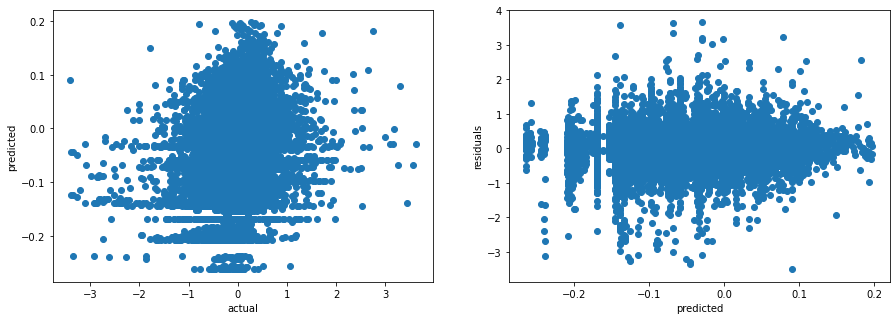

In [38]:
x_dat = dat[['V', 'timebin', 'ID']]
y_dat = dat['pupil']


predicted = res.predict(x_dat)
residuals = y_dat - predicted

f, axs = plt.subplots(1, 2, figsize = [15,5])

axs[0].scatter(y_dat, predicted)
axs[0].set_xlabel('actual')
axs[0].set_ylabel('predicted')

axs[1].scatter(predicted, residuals)
axs[1].set_xlabel('predicted')
axs[1].set_ylabel('residuals')



**Check for Normality of residuals**

/Users/sarah/anaconda3/envs/py3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Normality of error terms/residuals')

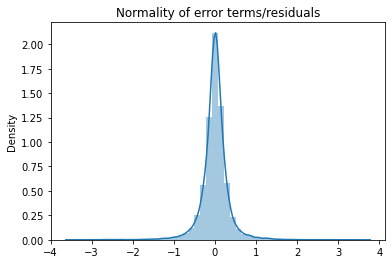

In [39]:
sns.distplot(residuals,kde=True)
plt.title('Normality of error terms/residuals')

### Pupil ~ V*congruency

In [47]:
dat_cong = dat[~(dat['congruency'].values == 'nan')]
res = smf.ols('pupil ~ ID + V*congruency', data = dat_cong).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  pupil   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     7.668
Date:                Tue, 10 Sep 2024   Prob (F-statistic):           2.04e-30
Time:                        11:06:32   Log-Likelihood:                -4805.5
No. Observations:               14184   AIC:                             9669.
Df Residuals:                   14155   BIC:                             9888.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.0578      0.016     -3.654      0.000      -0.089      -0.027
ID[T.3.0]                   0.0433      0.021      2.100      0.036       0.003       0.084
ID[T.4.0]                   0.0244      0.021      1.182      0.237      -0.016       0.065
ID[T.5.0]                   0.0533      0.025      2.132      0.033       0.004       0.102
ID[T.6.0]                   0.0175      0.020      0.857      0.391      -0.023       0.058
ID[T.8.0]                  -0.0329      0.021     -1.595      0.111      -0.073       0.008
ID[T.9.0]                  -0.0285      0.021     -1.376      0.169      -0.069       0.012
ID[T.10.0]                  0.0238      0.021      1.145      0.252      -0.017       0.065
ID[T.11.0]                  0.0085      0.021      0.412      0.680      -0.032       0.049
ID[T.12.0]                  0.0349      0.020      1.743      0.081      -0.004       0.074
ID[T.13.0]                 -0.0082      0.021     -0.401      0.689      -0.049       0.032
ID[T.14.0]                 -0.0190      0.043     -0.446      0.655      -0.103       0.065
ID[T.15.0]                  0.0236      0.020      1.177      0.239      -0.016       0.063
ID[T.16.0]                  0.0382      0.020      1.890      0.059      -0.001       0.078
ID[T.17.0]                 -0.0289      0.021     -1.387      0.166      -0.070       0.012
ID[T.19.0]                  0.0260      0.020      1.298      0.194      -0.013       0.065
ID[T.20.0]                  0.0193      0.021      0.927      0.354      -0.022       0.060
ID[T.21.0]                  0.0159      0.021      0.768      0.442      -0.025       0.056
ID[T.22.0]                  0.0254      0.021      1.228      0.220      -0.015       0.066
ID[T.24.0]                 -0.0678      0.021     -3.260      0.001      -0.109      -0.027
ID[T.25.0]                  0.0508      0.021      2.457      0.014       0.010       0.091
ID[T.26.0]                  0.0353      0.021      1.699      0.089      -0.005       0.076
ID[T.27.0]                 -0.0667      0.020     -3.329      0.001      -0.106      -0.027
ID[T.28.0]                  0.0172      0.021      0.835      0.403      -0.023       0.058
ID[T.29.0]                 -0.1019      0.021     -4.969      0.000      -0.142      -0.062
ID[T.30.0]                  0.0065      0.020      0.324      0.746      -0.033       0.046
congruency[T.incongr]      -0.0016      0.007     -0.236      0.813      -0.015       0.012
V                           0.0994      0.024      4.154      0.000       0.053       0.146
V:congruency[T.incongr]    -0.0311      0.030     -1.041      0.298      -0.090       0.027
==============================================================================
Omnibus:                     2917.713   Durbin-Watson:      

In [48]:
# Extract the p-values from the OLS regression result.
p_values = res.pvalues

# Perform multiple hypothesis testing correction on the p-values using the Benjamini-Hochberg method (FDR correction), with a significance level (alpha) of 0.05.
_, pvals_corrected, _, _ = statsmodels.stats.multitest.multipletests(p_values, alpha=0.05, method='fdr_bh')

# Convert the original and corrected p-values to a DataFrame for better visualization.
dat_p = p_values.to_frame()
dat_p.insert(1, "corrected", pvals_corrected)

# Save the DataFrame with original and corrected p-values to an Excel file.
dat_p.to_excel("output_pupil_ID-V-congruency.xlsx")
dat_p

,0,corrected
Intercept,2.589224e-04,0.002503
ID[T.3.0],3.574545e-02,0.129577
ID[T.4.0],2.371644e-01,0.384665
ID[T.5.0],3.299933e-02,0.129577
ID[T.6.0],3.913310e-01,0.508700
ID[T.8.0],1.108389e-01,0.267861
ID[T.9.0],1.687184e-01,0.349488
ID[T.10.0],2.520221e-01,0.384665
ID[T.11.0],6.801261e-01,0.739799
ID[T.12.0],8.135988e-02,0.235592


### Assumption Check

**Check for Homoscedasticity**

Text(0, 0.5, 'residuals')

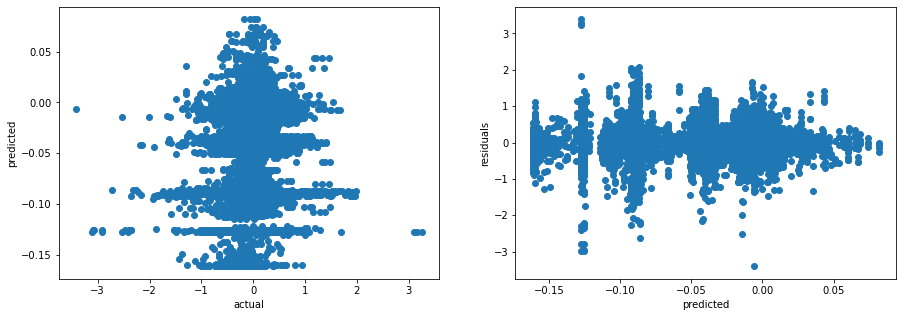

In [49]:
x_dat = dat_cong[['V', 'congruency', 'ID']]
y_dat = dat_cong['pupil']


predicted = res.predict(x_dat)
residuals = y_dat - predicted

f, axs = plt.subplots(1, 2, figsize = [15,5])

axs[0].scatter(y_dat, predicted)
axs[0].set_xlabel('actual')
axs[0].set_ylabel('predicted')

axs[1].scatter(predicted, residuals)
axs[1].set_xlabel('predicted')
axs[1].set_ylabel('residuals')



**Check for Normality of residuals**

/Users/sarah/anaconda3/envs/py3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Normality of error terms/residuals')

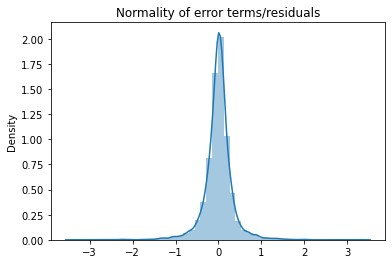

In [50]:
sns.distplot(residuals,kde=True)
plt.title('Normality of error terms/residuals')

## Pupil ~ V * timebin * congruency

In [51]:
dat_cong = dat[~(dat['congruency'].values == 'nan')]
res = smf.ols('pupil ~ ID +  V*timebin*congruency', data = dat_cong).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  pupil   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     12.77
Date:                Tue, 10 Sep 2024   Prob (F-statistic):           2.90e-81
Time:                        11:06:41   Log-Likelihood:                -4660.7
No. Observations:               14184   AIC:                             9403.
Df Residuals:                   14143   BIC:                             9713.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                -0.0175      0.018     -0.987      0.324      -0.052       0.017
ID[T.3.0]                                 0.0433      0.020      2.121      0.034       0.003       0.083
ID[T.4.0]                                 0.0244      0.020      1.194      0.233      -0.016       0.064
ID[T.5.0]                                 0.0533      0.025      2.153      0.031       0.005       0.102
ID[T.6.0]                                 0.0175      0.020      0.866      0.387      -0.022       0.057
ID[T.8.0]                                -0.0329      0.020     -1.610      0.107      -0.073       0.007
ID[T.9.0]                                -0.0285      0.021     -1.390      0.165      -0.069       0.012
ID[T.10.0]                                0.0238      0.021      1.157      0.247      -0.017       0.064
ID[T.11.0]                                0.0085      0.020      0.416      0.677      -0.031       0.048
ID[T.12.0]                                0.0349      0.020      1.760      0.078      -0.004       0.074
ID[T.13.0]                               -0.0082      0.020     -0.404      0.686      -0.048       0.032
ID[T.14.0]                               -0.0190      0.042     -0.451      0.652      -0.102       0.064
ID[T.15.0]                                0.0236      0.020      1.188      0.235      -0.015       0.062
ID[T.16.0]                                0.0382      0.020      1.909      0.056      -0.001       0.077
ID[T.17.0]                               -0.0289      0.021     -1.400      0.161      -0.069       0.012
ID[T.19.0]                                0.0260      0.020      1.311      0.190      -0.013       0.065
ID[T.20.0]                                0.0193      0.021      0.936      0.349      -0.021       0.060
ID[T.21.0]                                0.0159      0.020      0.776      0.438      -0.024       0.056
ID[T.22.0]                                0.0254      0.020      1.240      0.215      -0.015       0.066
ID[T.24.0]                               -0.0678      0.021     -3.292      0.001      -0.108      -0.027
ID[T.25.0]                                0.0508      0.020      2.481      0.013       0.011       0.091
ID[T.26.0]                                0.0353      0.021      1.716      0.086      -0.005       0.076
ID[T.27.0]                               -0.0667      0.020     -3.362      0.001      -0.106      -0.028
ID[T.28.0]                                0.0172      0.020      0.844      0.399      -0.023       0.057
ID[T.29.0]                               -0.1019      0.020     -5.018      0.000      -0.142      -0.062
ID[T.30.0]                                0.0065      0.020      0.327      0.743      -0.033       0.046
timebin[T

In [53]:
# Extract the p-values from the OLS regression result.
p_values = res.pvalues

# Perform multiple hypothesis testing correction on the p-values using the Benjamini-Hochberg method (FDR correction), with a significance level (alpha) of 0.05.
_, pvals_corrected, _, _ = statsmodels.stats.multitest.multipletests(p_values, alpha=0.05, method='fdr_bh')

# Convert the original and corrected p-values to a DataFrame for better visualization.
dat_p = p_values.to_frame()
dat_p.insert(1, "corrected", pvals_corrected)

# Save the DataFrame with original and corrected p-values to an Excel file.
dat_p.to_excel("output_pupil_ID-V-timebin-congruency.xlsx")
dat_p

,0,corrected
Intercept,3.238035e-01,5.310378e-01
ID[T.3.0],3.396766e-02,1.740843e-01
ID[T.4.0],2.325847e-01,4.583633e-01
ID[T.5.0],3.131453e-02,1.740843e-01
ID[T.6.0],3.866904e-01,5.840215e-01
ID[T.8.0],1.073737e-01,3.386403e-01
ID[T.9.0],1.645695e-01,4.217093e-01
ID[T.10.0],2.473891e-01,4.610433e-01
ID[T.11.0],6.771575e-01,7.600298e-01
ID[T.12.0],7.841031e-02,2.922566e-01


### Assumption Check

**Check for Homoscedasticity**

Text(0, 0.5, 'residuals')

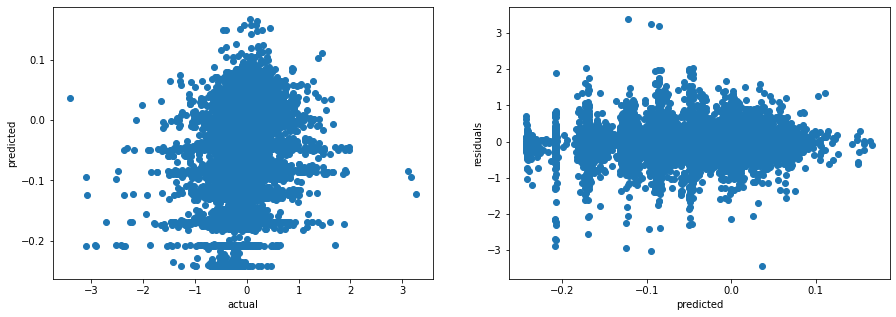

In [54]:
x_dat = dat_cong[['V', 'congruency', 'ID', 'timebin']]
y_dat = dat_cong['pupil']


predicted = res.predict(x_dat)
residuals = y_dat - predicted

f, axs = plt.subplots(1, 2, figsize = [15,5])

axs[0].scatter(y_dat, predicted)
axs[0].set_xlabel('actual')
axs[0].set_ylabel('predicted')

axs[1].scatter(predicted, residuals)
axs[1].set_xlabel('predicted')
axs[1].set_ylabel('residuals')



**Check for Normality of residuals**

/Users/sarah/anaconda3/envs/py3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Normality of error terms/residuals')

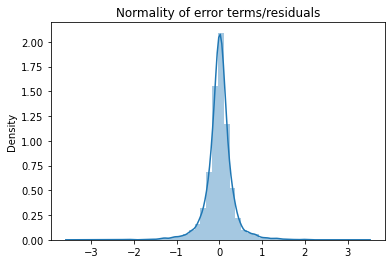

In [55]:
sns.distplot(residuals,kde=True)
plt.title('Normality of error terms/residuals')